This notebook was inspired by: https://www.kaggle.com/code/tanmay111999/air-passenger-forecast-arima-sarima

In [1]:
!pip install sktime
!pip install pmdarima

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
from sktime.utils.plotting import plot_correlations
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
import statsmodels.api as sm
from sktime.performance_metrics.forecasting import mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.5 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/air-passengers/AirPassengers.csv


In [2]:
df = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv', index_col=0)

In [3]:
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
y = df.iloc[:,0]

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Passengers'>)

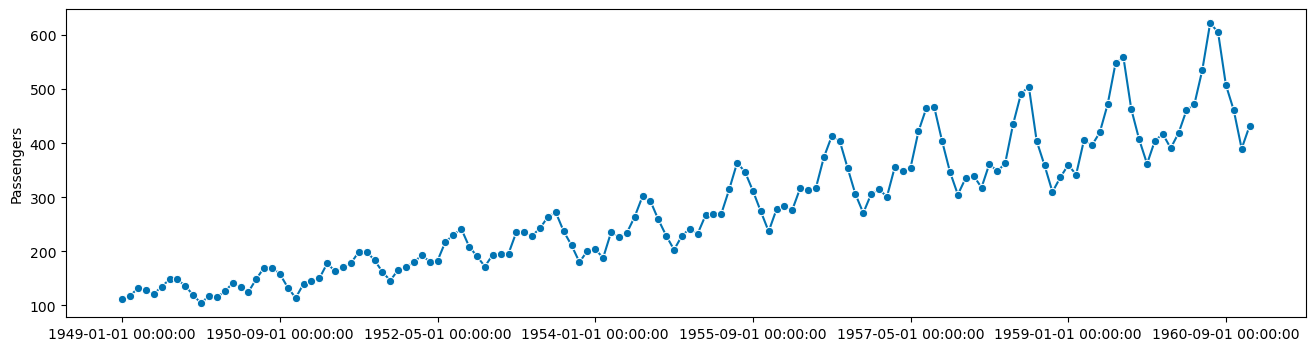

In [6]:
plot_series(y)

## Autocorrelations

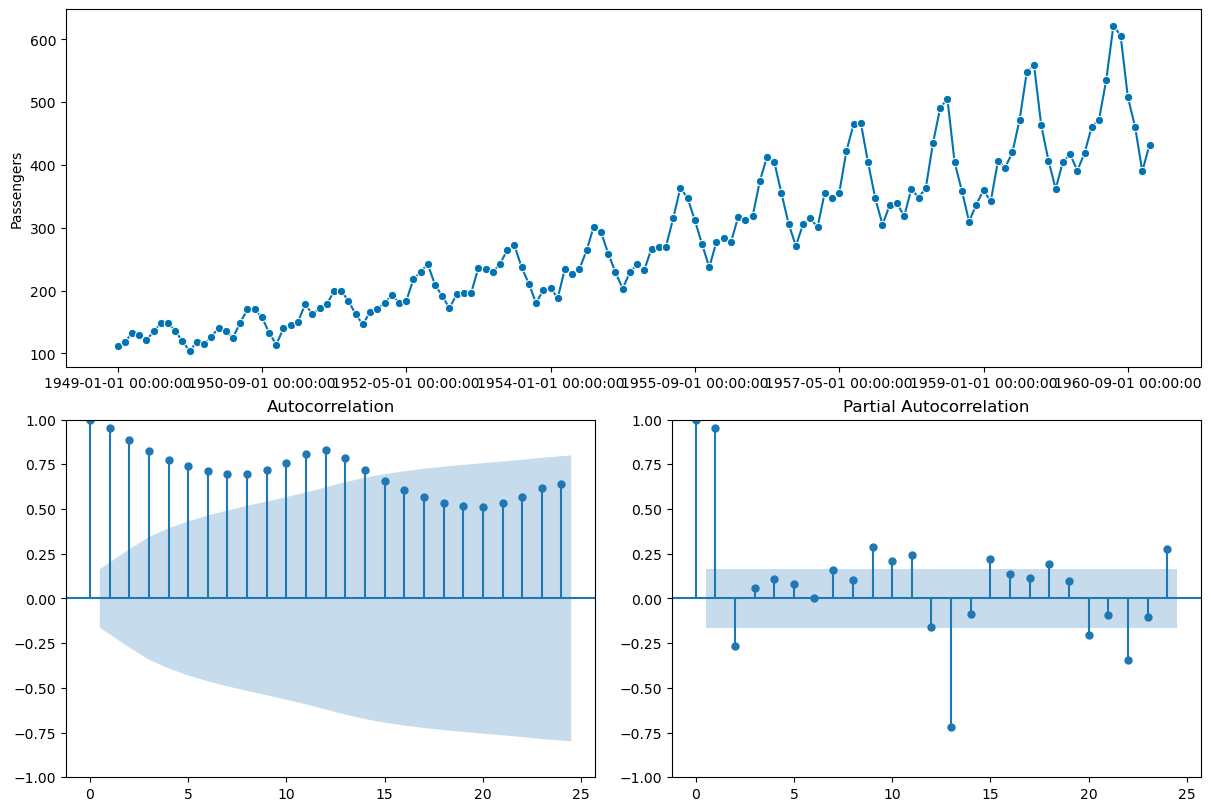

In [7]:
fig,ax = plot_correlations(y)

r12 is higher than for the other lags. This is due to the seasonal pattern in the data. The data have also a trend because the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in value.

## Decomposition

In [8]:
from statsmodels.tsa.seasonal import STL
decomposition = STL(y, robust=True).fit()
residuals = decomposition.resid
seasonal_factor = decomposition.seasonal
trend = decomposition.trend
seas_to_resid = np.nanmedian(abs(seasonal_factor) / abs(residuals))
trend_to_resid = np.nanmedian(abs(trend) / abs(residuals))
seas_strength = np.max([0, 1 - np.var(residuals) / np.var(residuals + seasonal_factor)])
trend_strength = np.max([0, 1 - np.var(residuals) / np.var(residuals + trend)])
print('Seas strength:', seas_strength, ' Trend strength:', trend_strength, ' Seas to resid:', seas_to_resid, ' Trend to resid:', trend_to_resid)

Seas strength: 0.9752906263380069  Trend strength: 0.9961766723045914  Seas to resid: 9.868055595560897  Trend to resid: 107.44517349045996


There is a strong seasonality and a strong trend (value close to 1).

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='resid'>)

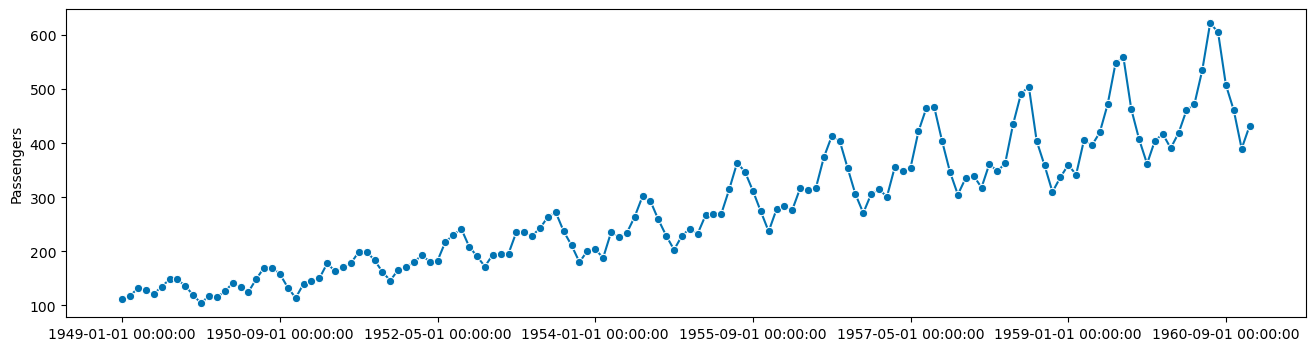

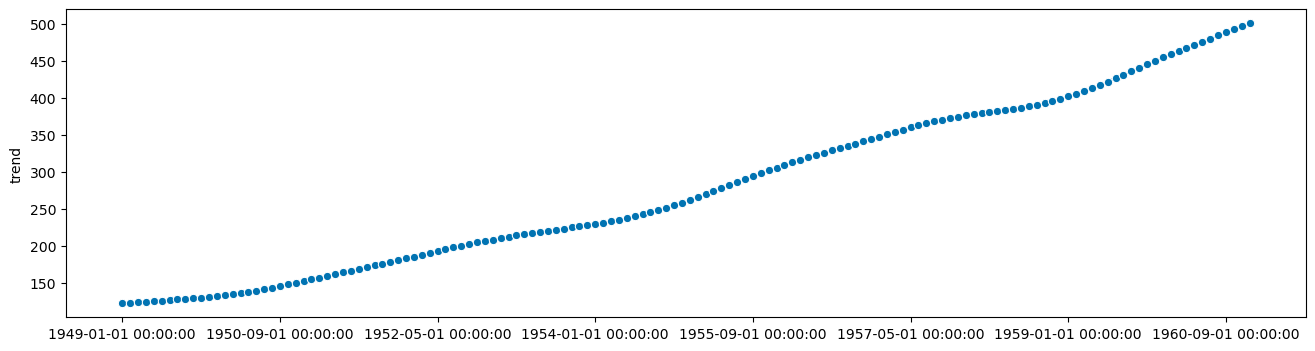

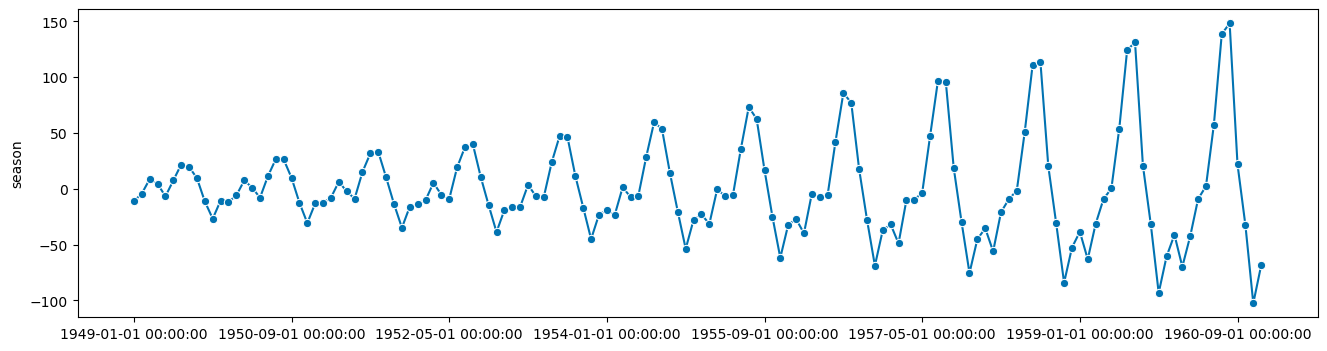

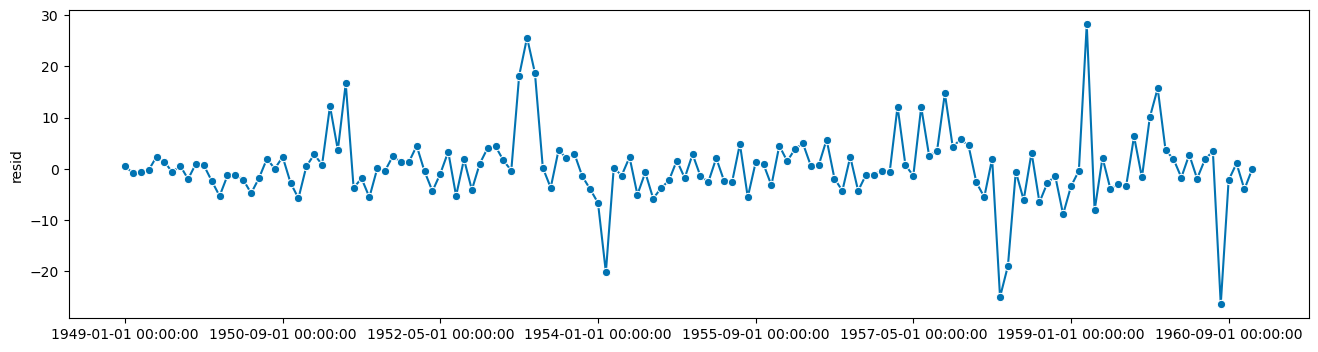

In [9]:
plot_series(y)
plot_series(trend)
plot_series(seasonal_factor)
plot_series(residuals)

## Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

adfuller(y)

(0.8153688792060498,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

Time series is non-stationary, because p-value is greater that 0.05, so we can't reject null hypothesis.

In [11]:
df_diff = df.diff()
df_diff = df_diff.dropna()

In [12]:
y = df_diff['Passengers']

In [13]:
adfuller(y)

(-2.8292668241700047,
 0.05421329028382478,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854085)

In [14]:
from statsmodels.tsa.seasonal import STL
decomposition = STL(y, robust=True).fit()
residuals = decomposition.resid
seasonal_factor = decomposition.seasonal
trend = decomposition.trend
seas_to_resid = np.nanmedian(abs(seasonal_factor) / abs(residuals))
trend_to_resid = np.nanmedian(abs(trend) / abs(residuals))
seas_strength = np.max([0, 1 - np.var(residuals) / np.var(residuals + seasonal_factor)])
trend_strength = np.max([0, 1 - np.var(residuals) / np.var(residuals + trend)])
print('Seas strength:', seas_strength, ' Trend strength:', trend_strength, ' Seas to resid:', seas_to_resid, ' Trend to resid:', trend_to_resid)

Seas strength: 0.9331835321410269  Trend strength: 0.0  Seas to resid: 6.008203218648678  Trend to resid: 0.6958751496091427


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='resid'>)

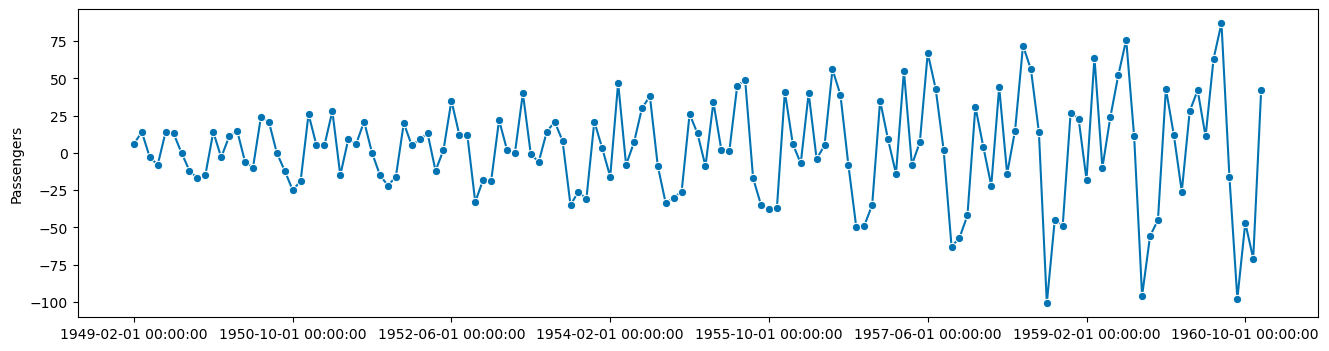

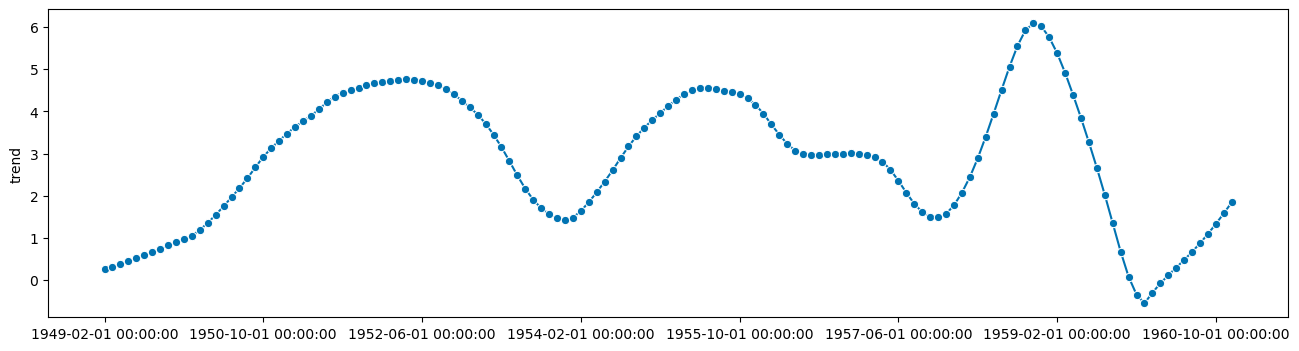

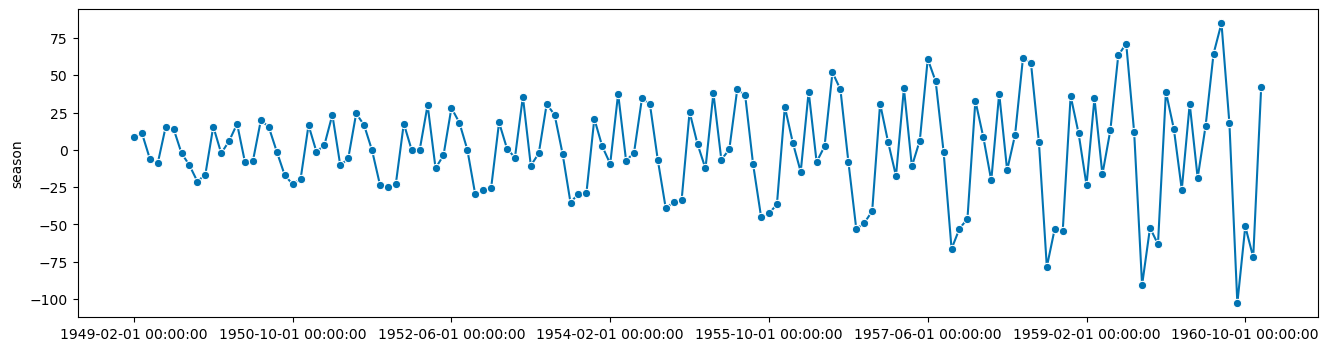

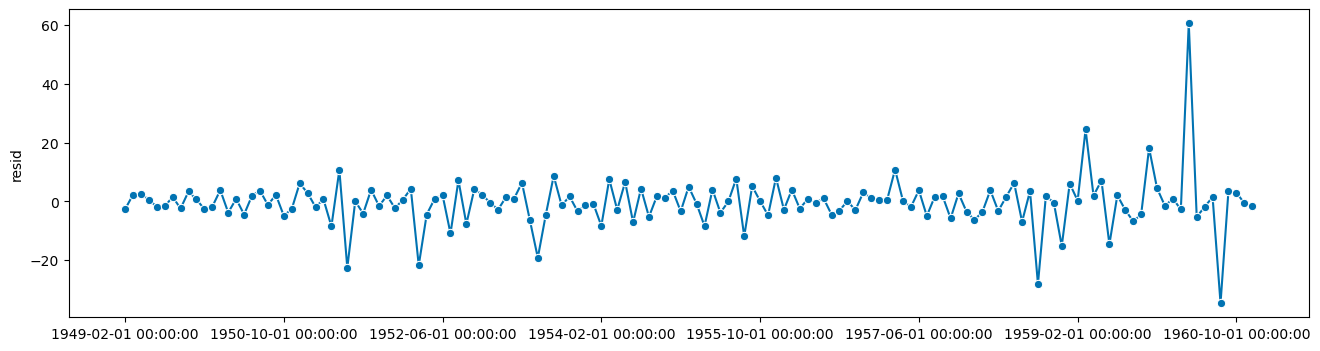

In [15]:
plot_series(y)
plot_series(trend)
plot_series(seasonal_factor)
plot_series(residuals)

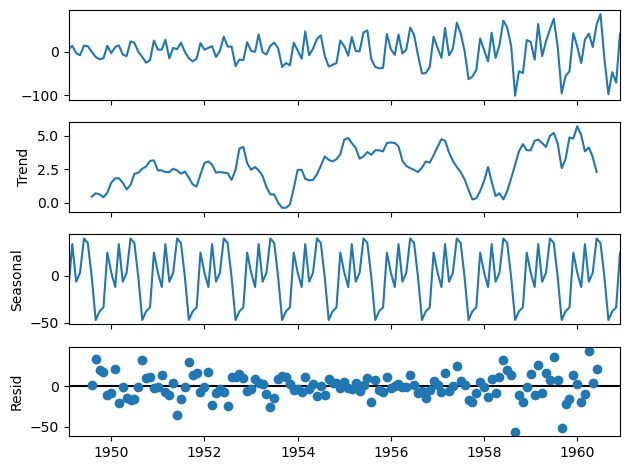

In [16]:
dec = sm.tsa.seasonal_decompose(df_diff,period = 12).plot()
plt.show()

## Modelling

### ARIMA

In [17]:
y.index = pd.PeriodIndex(y.index, freq="M")

In [18]:
y_train, y_test = temporal_train_test_split(y, test_size=0.2)

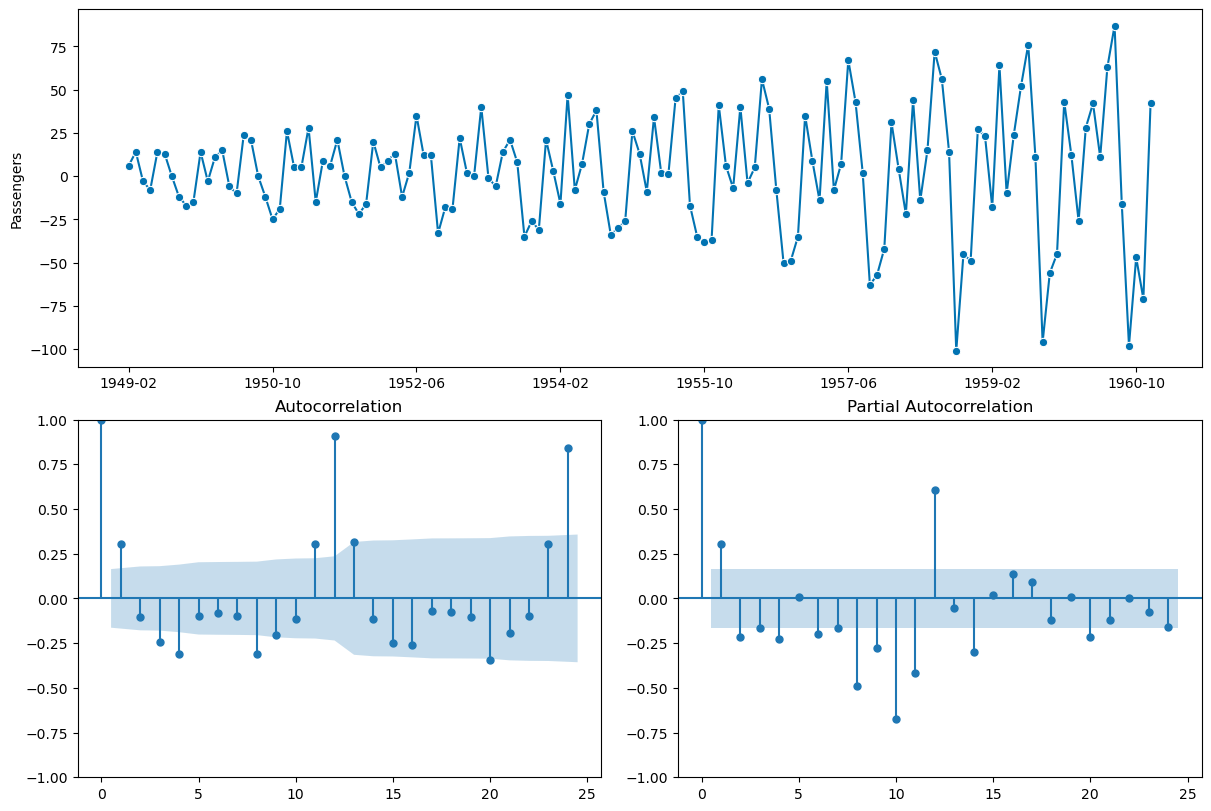

In [19]:
fig,ax = plot_correlations(y)

Selection criteria for the order of ARIMA model :

* p : Lag value where the Partial Autocorrelation (PACF) graph cuts off or drops to 0 for the 1st instance.
* d : Number of times differencing is carried out to make the time series stationary.
* q : Lag value where the Autocorrelation (ACF) graph crosses the upper confidence interval for the 1st instance.

p = 2, d = 1, q = 2

In [20]:
forecaster = ARIMA(order=(2, 1, 2), seasonal_order = (0, 1, 1, 12), suppress_warnings=True)
forecaster.fit(y_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  114
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -373.402
Date:                              Thu, 20 Jul 2023   AIC                            760.803
Time:                                      06:53:19   BIC                            779.109
Sample:                                  02-28-1949   HQIC                           768.214
                                       - 07-31-1958                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0225      0.044     -0.506      0.613      -0.109       0.065
ar.L1         -0.5272      0.784     -0.673      0.501      -2.063       1.008
ar.L2          0.0489      0.215      0.228      0.820      -0.372       0.470
ma.L1         -0.6184      0.981     -0.631      0.528      -2.540       1.304
ma.L2         -0.3775      0.783     -0.482      0.630      -1.911       1.156
ma.S.L12      -0.1062      0.090     -1.180      0.238      -0.283       0.070
sigma2        90.7363     48.570      1.868      0.062      -4.459     185.931
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.95   Prob(JB):                         0.25
Heteroskedasticity (H):               1.13   Skew:                             0.37
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Passengers'>)

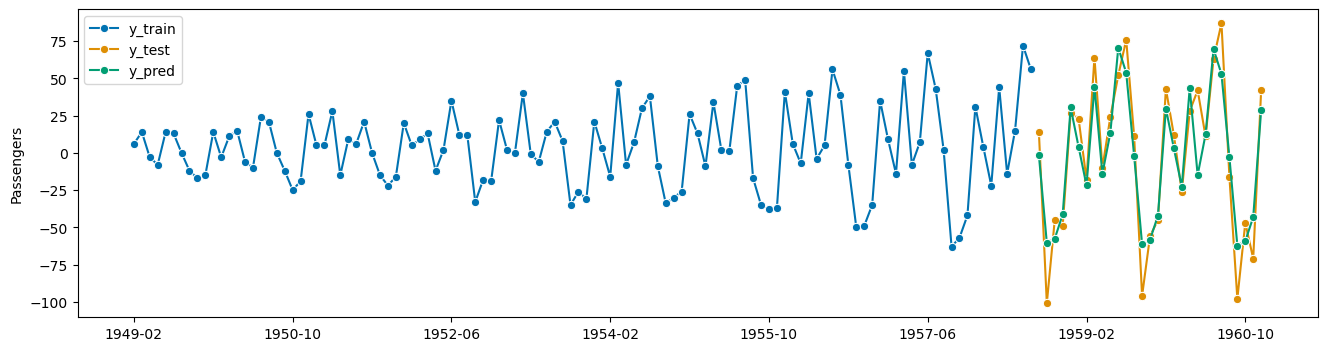

In [22]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [23]:
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  438.68387481159033
RMSE:  20.944781565143867


### Prophet

In [24]:
forecaster = Prophet(  
    seasonality_mode='multiplicative',
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={'country_name': 'USA'},
    yearly_seasonality=True)
forecaster.fit(y_train) 

06:53:21 - cmdstanpy - INFO - Chain [1] start processing
06:53:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_country_holidays={'country_name': 'USA'}, n_changepoints=9,
        seasonality_mode='multiplicative', yearly_seasonality=True)

In [25]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Passengers'>)

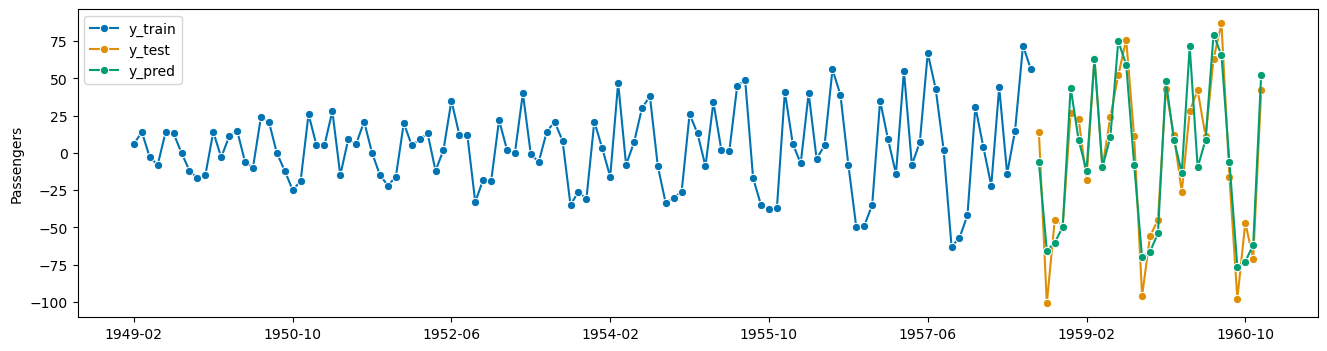

In [26]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [27]:
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  398.5360025903527
RMSE:  19.963366514452233
